## Identifiación de Outliers mediante HBOS tomando como base la diferencia entre los puntos contiguos como criterio

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

from funciones_OD import *

ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
sensor = "pm25"
redondeo = 4
variables = ['pm25']#,'humedad_relativa', 'temperatura'
for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

Nodo: 50 Faltan: 3
Nodo: 134 Faltan: 2
Nodo: 187 Faltan: 1
Nodo: 266 Faltan: 0

Ponderaciones: {2.4906: [94781, 27153.2115, 1.0, 1.0], 4.9811: [3514, 1006.7326, 0.0371, 0.0371], 7.4717: [440, 126.0528, 0.0046, 0.0046], 9.9622: [142, 40.6819, 0.0015, 0.0015], 12.4528: [29, 8.308, 0.0003, 0.0003], 14.9434: [11, 3.1513, 0.0001, 0.0001], 17.4339: [12, 3.4379, 0.0001, 0.0001], 19.9245: [5, 1.4324, 0.0001, 0.0001], 22.415: [4, 1.146, 0.0, 0.0], 24.9056: [2, 0.573, 0.0, 0.0], 27.3961: [0, 0.0, 0.0, 0.0], 29.8867: [5, 1.4324, 0.0001, 0.0001], 32.3773: [2, 0.573, 0.0, 0.0], 34.8678: [1, 0.2865, 0.0, 0.0], 37.3584: [1, 0.2865, 0.0, 0.0], 39.8489: [0, 0.0, 0.0, 0.0], 42.3395: [1, 0.2865, 0.0, 0.0]}

HBOS {0: 0.0, 1: 1.4306260903849541, 2: 2.337242168318426, 3: 2.8239087409443187, 4: 3.5228787452803374, 5: 4.0, 6: 4.0, 7: 4.0, 8: 10, 9: 10, 10: 10, 11: 4.0, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10}


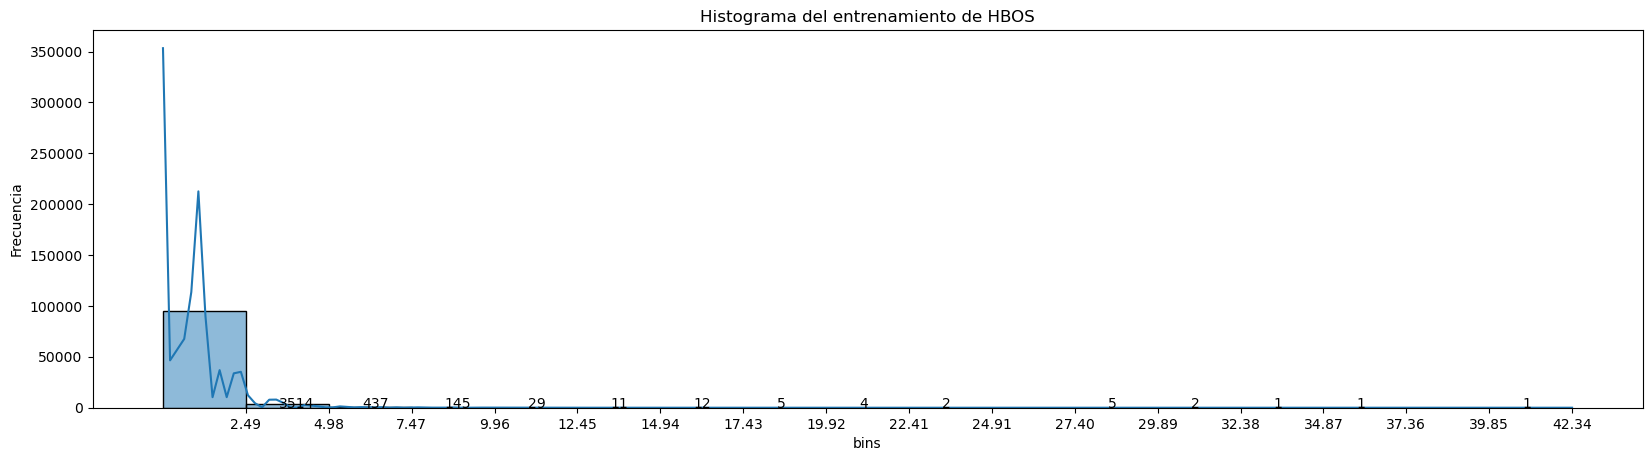

In [2]:
# ENTRENAMIENTO DE HBOS
pd.options.mode.chained_assignment = None  # default='warn'

porcentaje = 0.7
entreno, test = df_mix (entreno,porcentaje)
#nodos_entreno = [50, 134, 187, 266]
nodos_entreno = entreno.codigoSerial.unique().tolist()
entrenamiento = pd.DataFrame()

now = datetime.now()
time_hbos = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)


for i in nodos_entreno:
    inicio = datetime.now()
    print("Nodo:",i, "Faltan:", len(nodos_entreno)-(nodos_entreno.index(i)+1))
    fild = entreno.loc[entreno.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)
        
    if (len(fild)<=0):
        print("No hay datos del nodo", i)
        continue
        
    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

    entrenamiento = pd.concat([entrenamiento,fild],ignore_index=True)

HBOS = {}
hbos_inicio = datetime.now()
    
ks,kd,n,tam_bin,bins = calcula_k(entrenamiento,variables,redondeo) # Calcula los intervalos de forma dinámica y estática y el tamaño del bin para cada uno

for sensor in variables:
    
    # Asigna los valores a cada intervalo
    intervalos = asigna_ks(entrenamiento[sensor+'_dif'],bins) # Asignación de valores en intervalos de forma estática
    #intervalos = asigna_kd(n,entrenamiento[sensor],kd) # Asignación de valores en intervalos de forma dinpamica
            
    # Cálculo de ponderaciones de acuerdo con la frecuencia de cada intervalo (densidad de cada intervalo)
    ponderaciones = calcula_ponderaciones(intervalos,redondeo)
    print("\nPonderaciones:",ponderaciones)
            
    # Cálculo del scor HBOS para cada valor único.
    HBOS = calcula_HBOS(ponderaciones,HBOS)
    print("\nHBOS",HBOS)
    
hbos_fin = datetime.now()
time_hbos = time_hbos +(hbos_fin-hbos_inicio)


# GRAFICA DEL HISTOGRAMA
        
plt.figure(figsize=(20, 5), dpi=100)
sns.histplot(entrenamiento[sensor+'_dif'], bins=ks, kde=True, stat='count');
    
density, rangos, _= plt.hist(entrenamiento[sensor+'_dif'],density=True, bins=ks)
count, _= np.histogram(entrenamiento[sensor+'_dif'],bins)
for x,y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+1, y, num, fontsize=10)
                
plt.title('Histograma del entrenamiento de HBOS')
plt.xlabel('bins')
plt.ylabel('Frecuencia')
plt.xticks(bins)
    
plt.show() #dibujamos el histograma

In [3]:
# IDENTIFICACIÓN DE OUTLIERS POR HBOS  *****************************

datos_ori, datos2, outliers = synthetic_data(test,0.1,100)

datos2=datos2.assign(HBOS="N")
ident_outliers = pd.DataFrame()
nodos = datos2.codigoSerial.unique().tolist()

margen_HBOS = 4.5

cont = 0
for i in nodos:
    fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)

    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos
    

    for k in range(1,len(fild)):
        cont += 1
    
        # Validación de cada valor contra su respectivo score HBOS
        hbos_inicio = datetime.now()
        ponde = verifica_HBOS(HBOS,fild[variables[0]+'_dif'][k-1],bins)
        #print('posicion:',k,'valor:',fild[variables[0]+'_dif'][k-1],'ponde 1:',ponde)

        if  ponde > margen_HBOS:
            ponde = verifica_HBOS(HBOS,fild[variables[0]+'_dif'][k],bins)
            #print('posicion:',k,'valor:',fild[variables[0]+'_dif'][k],'ponde 2:',ponde)
            if  ponde > margen_HBOS: 
                fild.loc[k-1,"HBOS"]= "S"         
                            
        hbos_fin = datetime.now()
        time_hbos = time_hbos +(hbos_fin-hbos_inicio)
        
    fin = datetime.now()
    
    ident_outliers = pd.concat([ident_outliers,fild],ignore_index=True)
    
print("Tiempo HBOS:", time_hbos.time())
print("Tiempo total:", fin-inicio)
print("Cantidad de valores:",len(datos2))    
        
########################################################################

Se incluyeron 4542 Outliers
Tiempo HBOS: 00:00:07.910318
Tiempo total: 0:03:55.942594
Cantidad de valores: 45419


<ipython-input-4-fe69b52e6ebd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = ident_outliers[110:170][ident_outliers['HBOS'] == 'S']


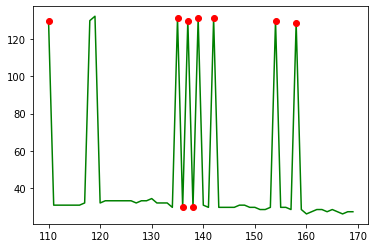

In [4]:
outliers = ident_outliers[110:170][ident_outliers['HBOS'] == 'S']
plt.plot(ident_outliers[110:170].index, ident_outliers[110:170].pm25, color="green",label="pm25")
plt.plot(outliers.index, outliers.pm25, 'o', color="red",label="Outliers")

plt.show()

In [5]:
ident_outliers[ident_outliers['HBOS'] == 'S']
#ident_outliers[0:30]

,codigoSerial,fecha,hora,temperatura,humedad_relativa,pm25,pm25_dif,pm25_outlier,HBOS
116,50,2020-02-14,01:59:00,22.98,80.02,149.6973,101.1734,49.6973,S
122,50,2020-02-14,02:05:00,22.90,79.96,150.8706,101.1733,50.8706,S
123,50,2020-02-14,02:06:00,22.89,79.97,48.5239,102.3467,N,S
124,50,2020-02-14,02:07:00,22.87,79.96,149.6973,101.1734,49.6973,S
129,50,2020-02-14,02:15:00,22.79,80.06,150.8706,102.3467,50.8706,S
...,...,...,...,...,...,...,...,...,...
41915,266,2020-02-07,22:57:00,19.14,82.46,30.1344,98.9326,N,S
41916,266,2020-02-07,22:58:00,19.14,82.46,129.0670,98.9326,29.067,S
41937,266,2020-02-07,23:19:00,19.12,83.28,131.2018,100.0000,31.2018,S
41949,266,2020-02-07,23:31:00,19.09,83.05,129.0670,99.4663,29.067,S


In [5]:
#datos2
matrix_conf (ident_outliers,'HBOS')

TP: 3685 TN: 40450 FP: 427 FN: 857
Datos totales: 45419
*************************************
Precisión: 0.8961575875486382
Exhaustividad: 0.8113166006164685
F1: 0.8516293043679225
F1: 0.8516293043679224
Exactitud: 0.971729892776151



(40450, 857, 427, 3685)

Precisión: [0.97925291 0.89615759]
Exhaustividad: [0.98955403 0.8113166 ]
F1: [0.98437652 0.8516293 ]
Exactitud: 0.971729892776151



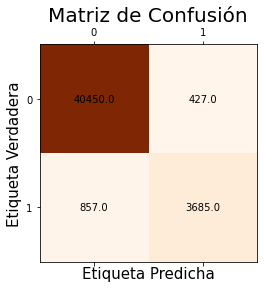

In [7]:
real = ident_outliers.pm25_outlier.tolist()
real = ['S' if value!='N' else value for value in real]
predicho = ident_outliers.HBOS.tolist()
confu_matrix (real,predicho)
